In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import sys
sys.path.append('../creme/')
import custom_model
import creme
import utils
import glob
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import pyranges as pr
import shutil
import pickle, os
import umap
from sklearn.preprocessing import StandardScaler
from collections import OrderedDict


2023-11-27 22:26:29.252201: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
model_name = 'enformer'
data_dir = '../data/'
test_results = f'../results/distance_test/{model_name}/'

In [3]:
tile_coords = pd.read_csv(f'../results/sufficiency_test/{model_name}/tile_coordinates.csv', index_col='Unnamed: 0').T
tss_tile = tile_coords.loc['tss'].T.values
cre_tile_coords = tile_coords.loc[[t for t in tile_coords.index if 'tss' not in t]]
cre_tiles_starts = cre_tile_coords[0].values
cre_tiles_starts_abs = np.abs(cre_tiles_starts - tss_tile[0]) // 1000

In [4]:
cre_df = pd.read_csv(f'../results/sufficiency_test/{model_name}_selected_cres.csv')


In [5]:
cre_df.groupby(['cell_line', 'context', 'tile class']).count()['seq_id']

cell_line  context    tile class
GM12878    enhancing  Enhancer       46
           neutral    Enhancer       33
                      Silencer       22
           silencing  Enhancer       48
                      Silencer      108
K562       enhancing  Enhancer       77
           neutral    Enhancer      145
                      Silencer       80
           silencing  Enhancer      537
                      Silencer      514
PC-3       enhancing  Enhancer       36
           neutral    Enhancer       20
                      Silencer       11
           silencing  Enhancer       42
                      Silencer       81
Name: seq_id, dtype: int64

In [30]:
cre_df['tile start relative to tss'] =  np.abs(cre_df['tile_start'] - tss_tile[0]) // 1000


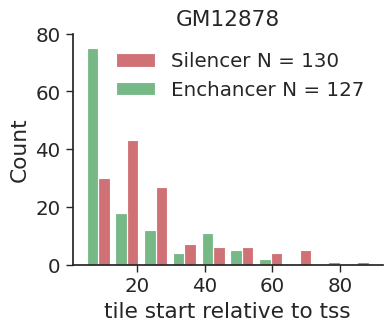

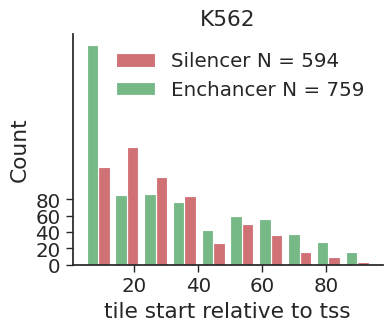

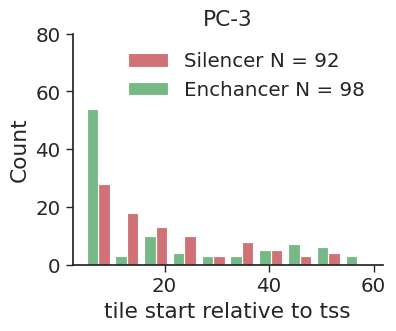

In [31]:

sns.set(font_scale = 1.3)
sns.set_style(style='white')
plt.rcParams['xtick.major.size'] = 5
plt.rcParams['xtick.major.width'] = 1

plt.rcParams['ytick.major.size'] = 5
plt.rcParams['ytick.major.width'] = 1
plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = True
color_map = {'Silencer': 'r', 'Enhancer': 'g'}
for cell, df in cre_df.groupby('cell_line'):
    fig, ax = plt.subplots(1, 1, figsize=[4,3])
    N = ({r[0]: r[1] for _,r in df.groupby('tile class').count().iloc[:,1].reset_index().iterrows()})
    sns.histplot(data=df, x='tile start relative to tss', hue='tile class', multiple="dodge", shrink=.8, ax=ax,bins=10, palette=color_map, alpha=0.8)
    ax.set_yticks([0, 20, 40, 60, 80])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.legend([f'Silencer N = {N["Silencer"]}', f'Enchancer N = {N["Enhancer"]}'], frameon=False)
    plt.title(cell)
    plt.show()

In [5]:
track_index = [4824, 5110, 5111]
target_df = pd.read_csv(f'{data_dir}/{model_name}_targets_human.txt', sep='\t')
cell_lines = [utils.clean_cell_name(target_df.iloc[t]['description']) for t in track_index]
cell_lines

['PC-3', 'GM12878', 'K562']

In [6]:
compiled_res = OrderedDict()
for i, cell_line in enumerate(cell_lines):
    compiled_res[cell_line] = {'Enhancer': {'enhancing':[], 'silencing':[], 'neutral': []}, 
                               'Silencer': {'enhancing':[], 'silencing':[], 'neutral': []}}

    cre_df_cell = cre_df[cre_df['cell_line'] == cell_line]

    for j, (_, row) in tqdm(enumerate(cre_df_cell.iterrows())):
        tile_start, tile_end = [row['tile_start'], row['tile_end']]
        result_path = f'{test_results}/{row["seq_id"]}_{tile_start}_{tile_end}.pickle'
        res = utils.read_pickle(result_path)
        control = res['mean_control'][447:449,i].mean()
        test = res['mean_mut'][:, 447:449, i].mean(axis=-1)
        # norm_effects = test / control
        norm_effects = test / np.max(test)
        compiled_res[cell_line][row['tile class']][row['context']].append(norm_effects)



190it [00:00, 5416.49it/s]
257it [00:00, 5568.97it/s]
1353it [00:00, 5674.97it/s]


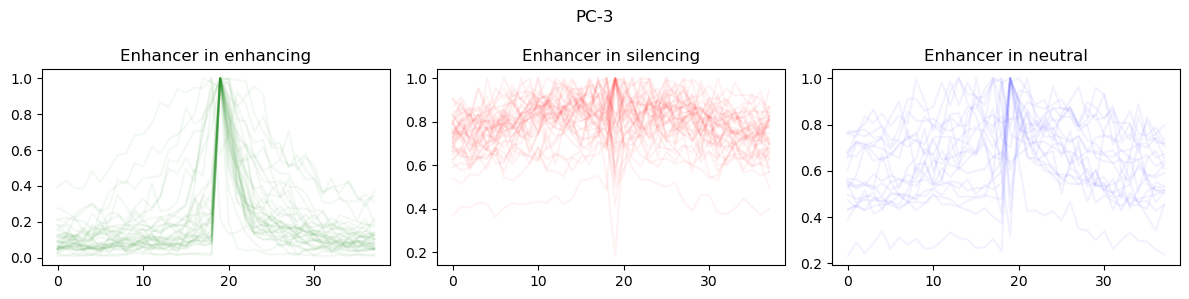

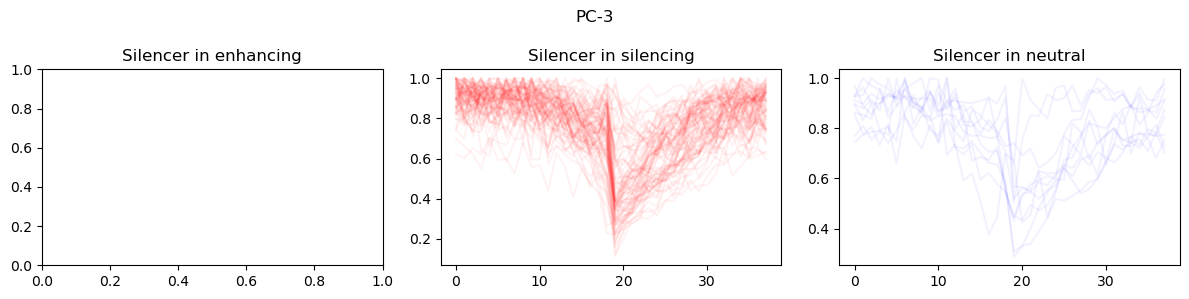

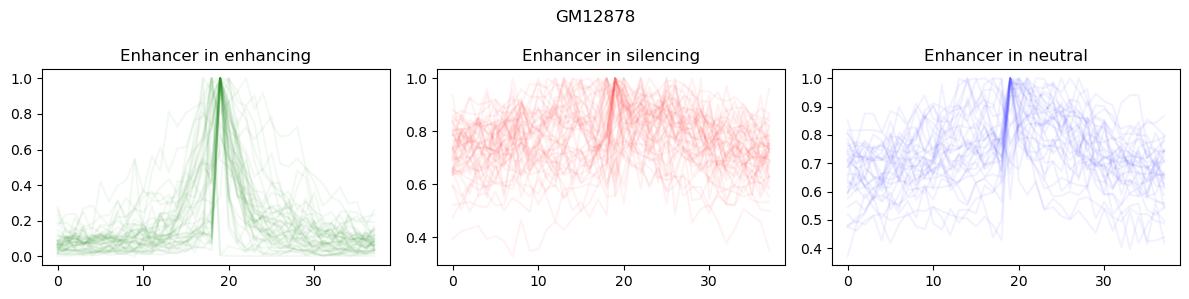

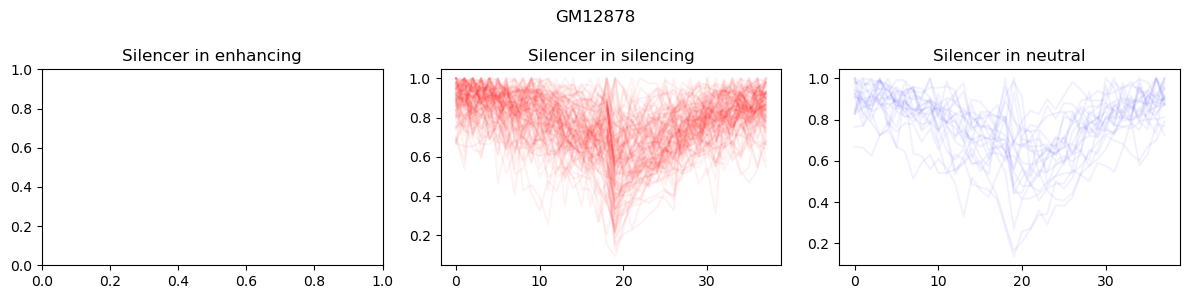

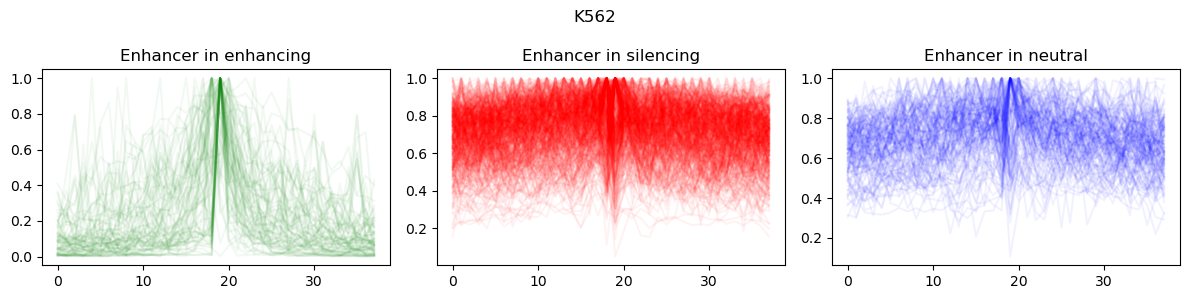

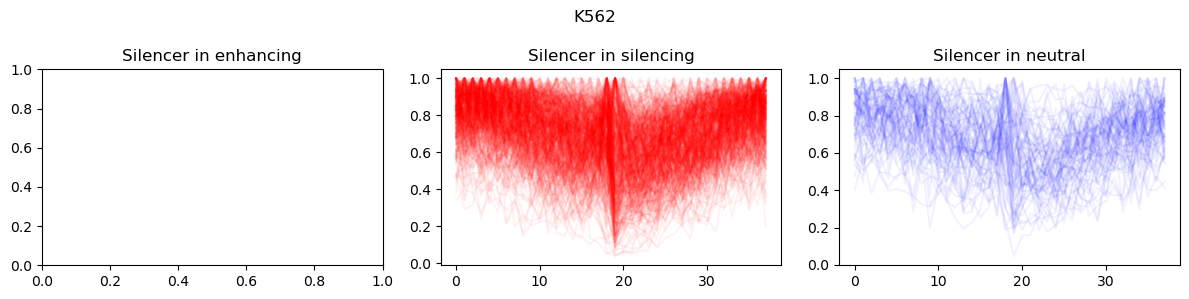

In [7]:
context_color_map = {'silencing': 'r', 'enhancing': 'g', 'neutral': 'b'}
for cell_line in ['PC-3', 'GM12878', 'K562']:
    for cre in ['Enhancer', 'Silencer']:
        fig, axes = plt.subplots(1, 3, figsize=[12, 3])
        for c, context in enumerate(['enhancing', 'silencing', 'neutral']):
            for line in (compiled_res[cell_line][cre][context]):
                axes[c].plot(line, alpha=0.05, color=context_color_map[context])
            axes[c].set_title(f'{cre} in {context}')
        plt.suptitle(cell_line)
        plt.tight_layout()
        plt.show()

In [16]:
def plot_umap(x, hue, ax):
    reducer = umap.UMAP(random_state=42)
    scaled_data = StandardScaler().fit_transform(x)
    embedding = reducer.fit_transform(scaled_data)
    sns.scatterplot(
                x=embedding[:, 0],
                y=embedding[:, 1],
                hue=hue,
                ax=ax)
    # plt.gca().set_aspect('equal', 'datalim')
    return embedding

/home/toneyan/.conda/envs/tf/lib/python3.9/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


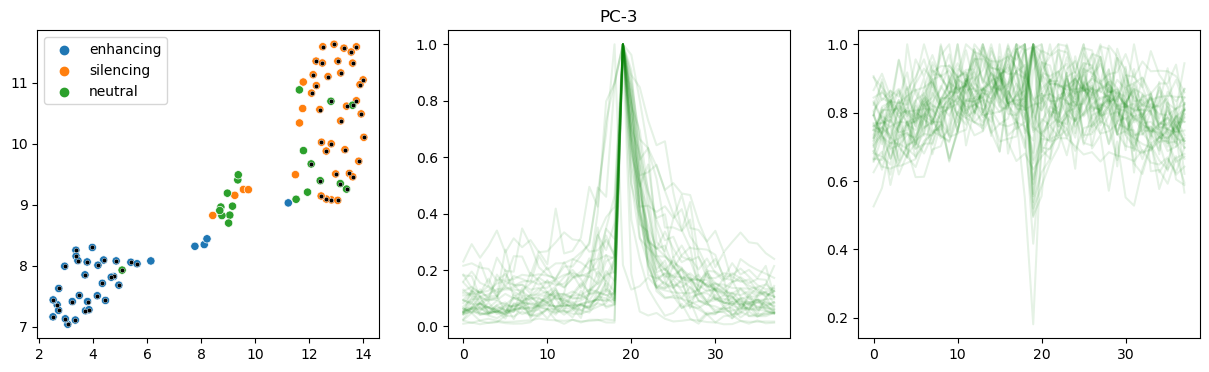

/home/toneyan/.conda/envs/tf/lib/python3.9/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


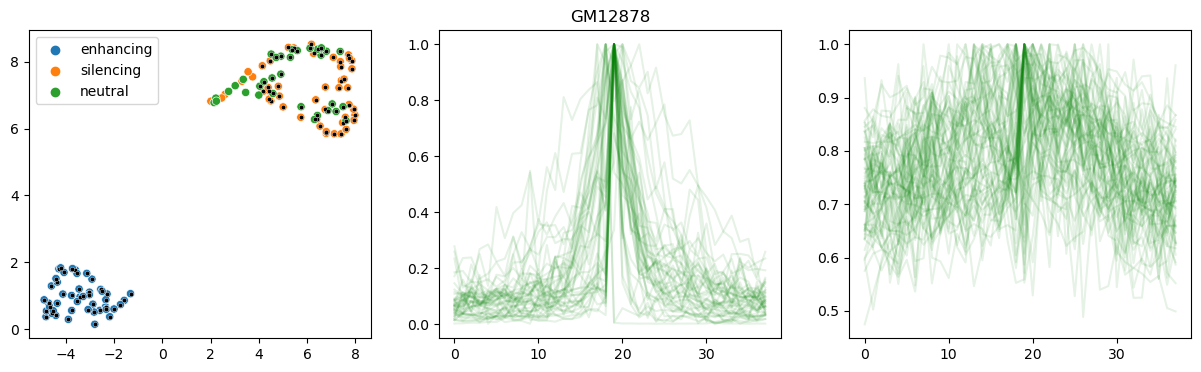

/home/toneyan/.conda/envs/tf/lib/python3.9/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


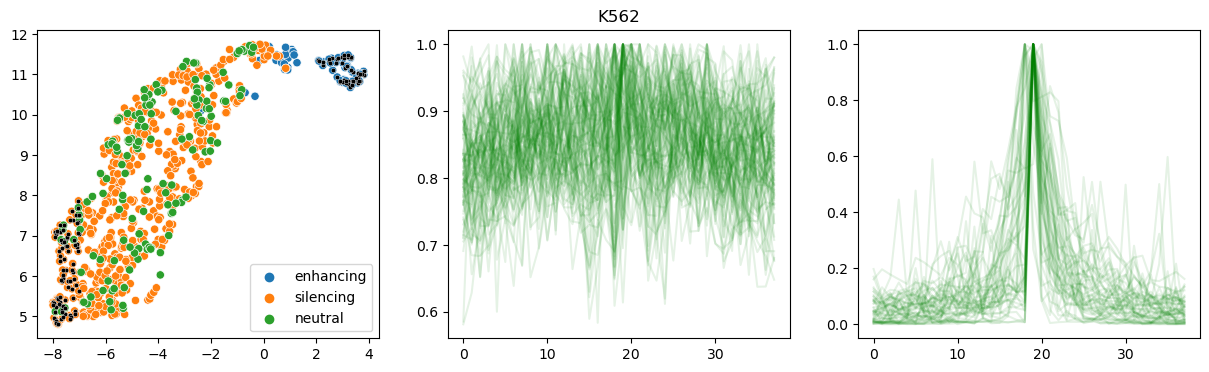

In [28]:
thresholds = [[6, 12], [0, 4], [-7, 2]]
for i, (cell_line, cre_context_vals) in enumerate(compiled_res.items()):
    # for cre, context_vals in cre_context_vals.items():
    cre = 'Enhancer'
    context_vals = cre_context_vals[cre]
    vals = []
    labels = []
    for k, v in context_vals.items():
        if len(v):
            vals.append(v)
            for _ in range(len(v)):
                labels.append(k)
    _, axes = plt.subplots(1, 3, figsize=[15, 4])

    emb = plot_umap(np.concatenate(vals), labels, axes[0])
    selected_points = np.argwhere(emb[:, 0] < thresholds[i][0]).flatten()
    sns.scatterplot(x=emb[selected_points,0], y=emb[selected_points,1], ax=axes[0], color='k', s=10)
    axes[1].plot(np.concatenate(vals)[selected_points].T, alpha=0.1, c='g');
    axes[1].set_title(cell_line)
    selected_points = np.argwhere(emb[:, 0] > thresholds[i][1]).flatten()
    sns.scatterplot(x=emb[selected_points,0], y=emb[selected_points,1], ax=axes[0], color='k', s=10)
    axes[2].plot(np.concatenate(vals)[selected_points].T, alpha=0.1, c='g');
    # axes[2].set_ylim(0,1)
    plt.show()

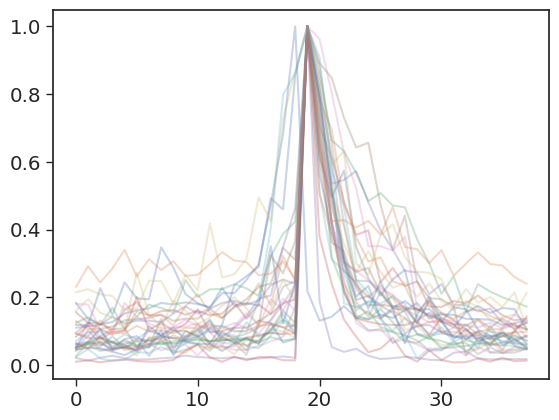

In [270]:
plt.plot(np.concatenate(vals)[np.argwhere(emb[:, 0] < 6).flatten()].T, alpha=0.3);

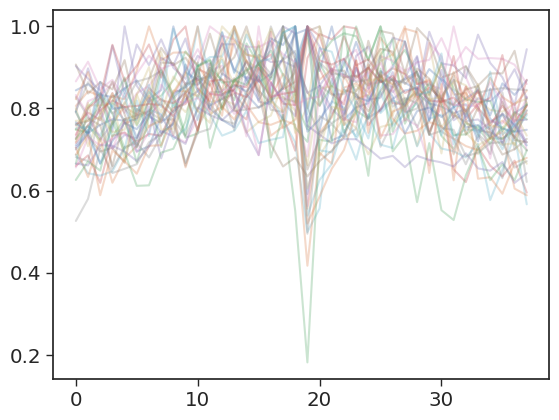

In [271]:
plt.plot(np.concatenate(vals)[np.argwhere(emb[:, 0] > 12).flatten()].T, alpha=0.3);